In [1]:
import sys
sys.path.append("../")

import dill
import pathlib
import numpy as np
import pandas as pd
import seaborn as sn
import torch.nn as nn
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

from utils import evaluate,cifar10_loader
from grid_search_bit_quantizer import load_resnet
from pytorch_resnet.resnet import resnet32,resnet44,resnet20
from quantizer import get_layers_path,getattr_by_path_list,BitQuantizer


# BitQuantizer

A layer is parametrized by Number of functions **(Nf)**, Number of bits **(Nb)**. Nf is set *min(Nf,number of output units (channel for conv layers) )*. After fixing Nb there are $2^{Nb}$ quantization levels. A value is quantized to the nearest level.

$$
\begin{align}
 w &= [w_1,w_2,w_3,..,w_m] \\
 f &= [f_1,f_2,..,f_{nb}] \\
 E &= \{-1,1\}^{nb}  \\
 Quant(w_i) &= min_i(f^T.e_j) \\
            &e_j \epsilon E 
\end{align}
$$

Quantizing a 32 bit float layer with NumParameters(Np) reduces the memory requirement from


$$
Np * 32 $$
to  
$$ Np.{Nb} + Nf.Nb.32 \approx Np.{Nb}$$ 
 $$Np \gg Nf $$
 

We minimize

$$
\begin{align}
   E[(Quant(w)-w)^2] = E[ (F^T.E_w-w)^2 ]
\end{align}
$$

which has a closed form solution for F

$$
\begin{align}
F = (E_w^T.E_w)^{-1}E_w^T.w
\end{align}
$$

The matrix $E_w$ might not be invertible,which is most likely the case as multiple w's would have the same encoding vector. So we use the psuedo inverse to find the least square solution.

$$
\begin{align}
F = E_w^{+}.w
\end{align}
$$

Finding the inverse in every forward pass slows down the network. As an alternative we add the mean square error term to the loss of the network and optimize it together in back propogation.

$$
NewLoss = OldLoss + \sum_{layers}(F^T.E_w-w)^2  
$$

## Grid search


In [2]:
df = pd.read_csv("./grid_search/runs.csv")
df["test"] = df["test_acc_before_hashing"]
df["train"] = df["train_acc_before_hashing"]
df["test_hash"] = df["test_acc_after_hashing"]
df["train_hash"] = df["train_acc_after_hashing"]

cols = ["model_name","n_bits","n_fs","train","test","test_hash","train_hash"]
df = df[cols]

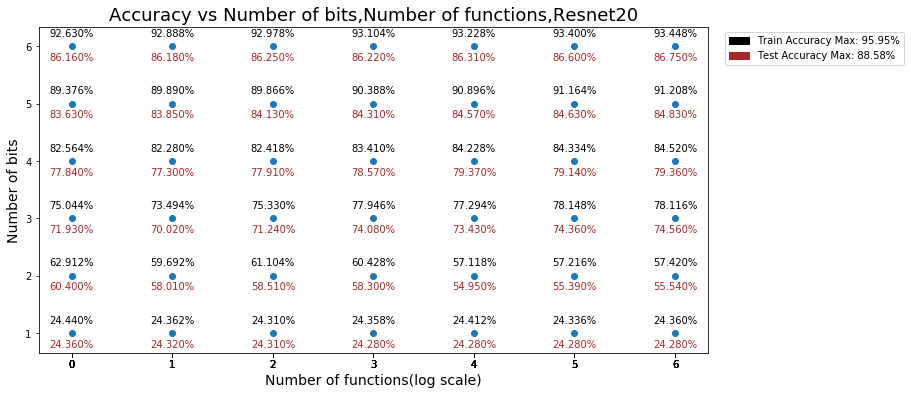

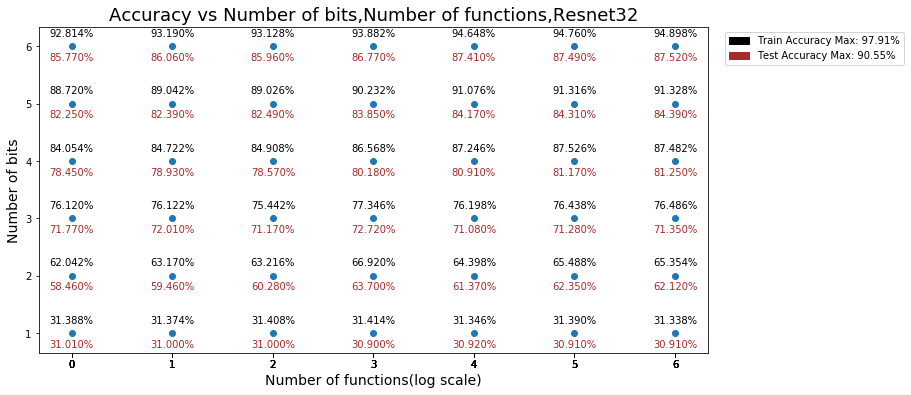

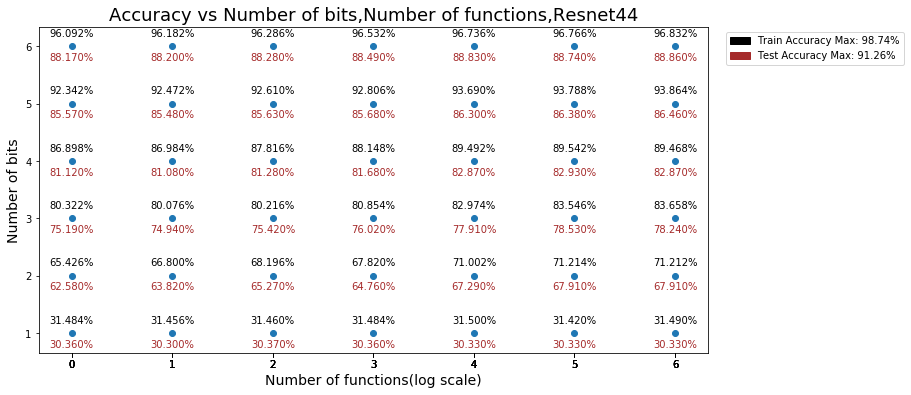

In [3]:
pretrained_accuracy = {
    'resnet20': {'train': 0.95946, 'test': 0.8858},
    'resnet32': {'train': 0.97912, 'test': 0.9055},
    'resnet44': {'train': 0.98736, 'test': 0.9126}
}

models = ["resnet20","resnet32","resnet44"]
for model in models:
    model_df = df[df["model_name"] == model]

    x = np.array(model_df["n_fs"])
    y = np.array(model_df["n_bits"])
    train_hash = np.array(model_df["train_hash"])
    test_hash = np.array(model_df["test_hash"])
    
    lx = np.log2(x)
    fig,ax = plt.subplots(figsize=(12,6))
    ax.set_xticks(lx)
    ax.set_yticks(np.arange(10))
    ax.scatter(lx,y)
    points = list(zip(lx,y) )

    z1s = [ f"{x*100:.3f}%" for x in train_hash ]
    z2s = [ f"{x*100:.3f}%" for x in test_hash ]

    for z1,z2,point in zip(z1s,z2s,points):
        ax.annotate(
            z1,
            point,
            textcoords="offset points", # how to position the text
            xytext=(0,10), 
            ha='center' ,
            color = "black"

        )

        ax.annotate(
            z2,
            point,
            textcoords="offset points", # how to position the text
            xytext=(0,-14), 
            ha='center' ,
            color = "brown"

        )
    ax.set_xlabel("Number of functions(log scale)",fontsize=14)
    ax.set_ylabel("Number of bits",fontsize=14)
    ax.set_title(f"Accuracy vs Number of bits,Number of functions,{model.capitalize()}",fontsize=18)

    handles, labels = ax.get_legend_handles_labels()

    train_label = f"Train Accuracy Max: {pretrained_accuracy[model]['train']*100:.2f}%"
    test_label = f"Test Accuracy Max: {pretrained_accuracy[model]['test']*100:.2f}%"
    
    patch1 = mpatches.Patch(color='black', label=train_label)
    patch2 = mpatches.Patch(color='brown', label=test_label)
                            
    handles.append(patch1) 
    handles.append(patch2)
                            

    legend_x = 1.3
    legend_y = 1
    plt.legend(handles=handles, loc='upper right',bbox_to_anchor=(legend_x, legend_y))

    plt.show()

### Pretrained vs Quantized

In [4]:
fp = lambda name:f"../pytorch_resnet/pretrained_models/{name}.th"
trainloader,testloader = cifar10_loader(256,"../../data")

In [5]:
# model_names = ["resnet20","resnet32","resnet44"]
# models = [resnet20,resnet32,resnet44]

# pretrained_accuracy = {}

# for model_name,model_fn in zip(model_names,models):
#     model = model_fn()
#     model.load_state_dict(load_resnet(fp(model_name)))
#     model.cuda()

#     train_acc = evaluate(model,trainloader,True)
#     test_acc = evaluate(model,testloader,True)
    
#     stat = {
#         "train":train_acc,
#         "test" :test_acc
#     }
#     pretrained_accuracy[model_name] = stat

# print(pretrained_accuracy)

In [6]:
pretrained_accuracy = {
    'resnet20': {'train': 0.95946, 'test': 0.8858},
    'resnet32': {'train': 0.97912, 'test': 0.9055},
    'resnet44': {'train': 0.98736, 'test': 0.9126}
}


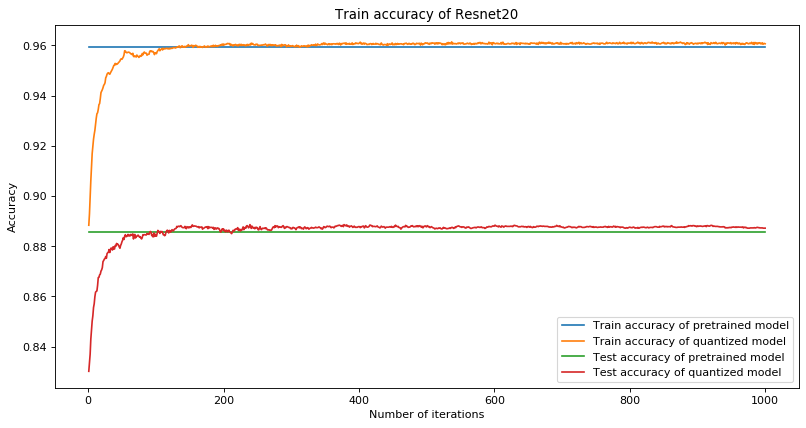

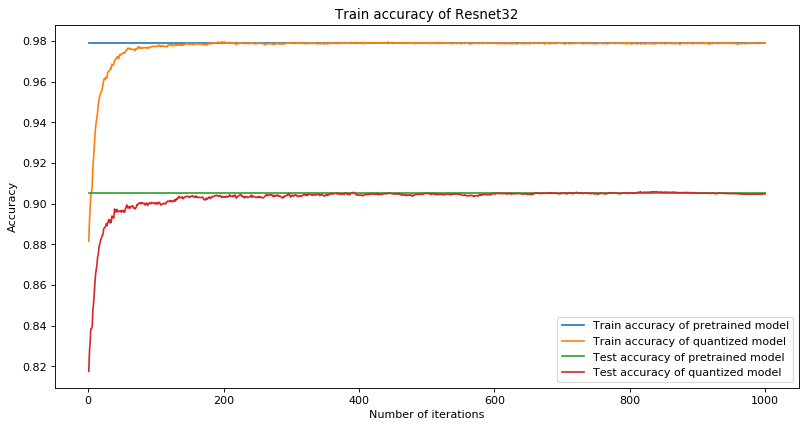

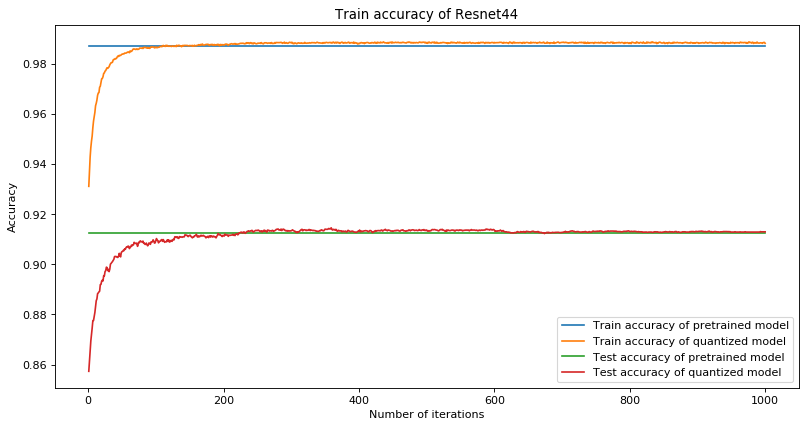

In [7]:
model_names = ["resnet20","resnet32","resnet44"]
for model_name in model_names:
    fp = lambda x:f"/home/aghinsa/Documents/workspace/The_Eye/global/HashedConv/workspace/quant/inference/1000_iters/{x}/"
    train = pd.read_csv(pathlib.Path(fp(model_name)) / "train_acc",sep=" ",names=["time","acc","iter"])
    test = pd.read_csv(pathlib.Path(fp(model_name)) / "test_acc",sep=" ",names=["time","acc","iter"])

    ll = len(train.acc)
    x = np.arange(ll)+1
    acc = train["acc"]

    plt.figure(figsize=(12,6),dpi=80)

    plt.plot(x,[pretrained_accuracy[model_name]['train']]*ll,label = "Train accuracy of pretrained model")
    plt.plot(x,acc,label = "Train accuracy of quantized model")

    acc = test["acc"]
    plt.plot(x,[pretrained_accuracy[model_name]['test']]*ll,label = "Test accuracy of pretrained model")
    plt.plot(x,acc,label = "Test accuracy of quantized model")


    plt.title(f"Train accuracy of {model_name.capitalize()}")
    plt.xlabel("Number of iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc="best")
    plt.savefig(f"pretrained_vs_quantized_{model_name}")
    plt.show()

### Analyzing weight distributions

In [8]:
model = resnet32()
fp = lambda name:f"../pytorch_resnet/pretrained_models/{name}.th"
model.load_state_dict(load_resnet(fp("resnet32")))

<All keys matched successfully>

In [9]:
with open("../checkpoint_bit_quantizer/resnet32_quantizer",'rb') as f:
    bit_quantizer = dill.load(f)
hashed_model = bit_quantizer.get_hashed_model()
hashed_model.cpu();

/home/aghinsa/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


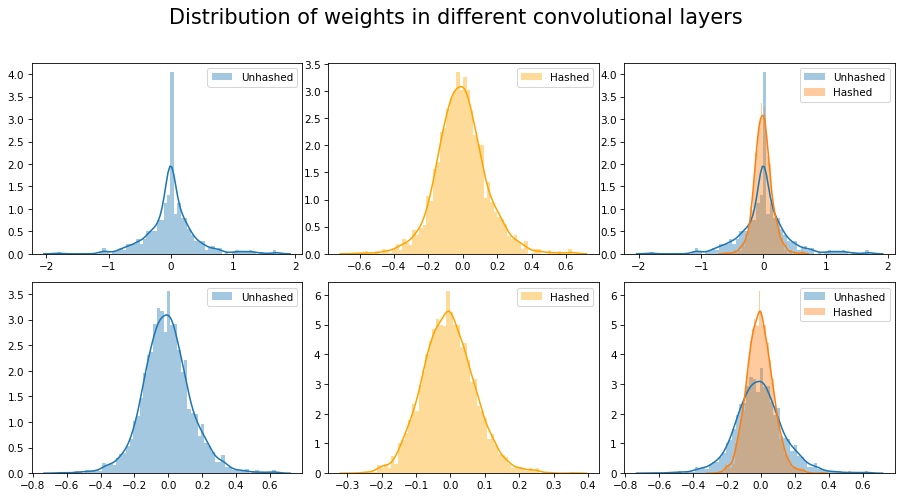

In [10]:
layer_paths = get_layers_path(model)
conv_layers = [ getattr_by_path_list(model,p) for p in layer_paths  ]
conv_layers = [x for x in conv_layers if isinstance(x,nn.Conv2d)]
to_view = [0,2,18,22]
conv_layers_model = [conv_layers[x] for x in to_view]

layer_paths = get_layers_path(hashed_model)
conv_layers = [ getattr_by_path_list(hashed_model,p) for p in layer_paths  ]
conv_layers = [x for x in conv_layers if isinstance(x,nn.Conv2d)]
to_view = [2,18,0,22]
to_view = [2,18] # Good perfomance
conv_layers_hashed_model = [conv_layers[x] for x in to_view]


# plotting

n = 2
fig, ax = plt.subplots(n,3, figsize=(12,6),dpi=75)

for i in range(n):
    layer = conv_layers_model[i]
    w = layer.weight.data
    j = 0
    ax[i][j] = sn.distplot(w.reshape(-1,1),bins=64,norm_hist=False,ax=ax[i][j],label="Unhashed")

    layer = conv_layers_hashed_model[i]
    j = 1
    w = layer.weight.data
    ax[i][j] = sn.distplot(w.reshape(-1,1),bins=64,norm_hist=False,
                           ax=ax[i][j],color='orange',label="Hashed")
    
    j = 2
    
    layer = conv_layers_model[i]
    w = layer.weight.data
    ax[i][j] = sn.distplot(w.reshape(-1,1),bins=64,norm_hist=False,ax=ax[i][j],label="Unhashed")

    layer = conv_layers_hashed_model[i]
    w = layer.weight.data
    ax[i][j] = sn.distplot(w.reshape(-1,1),bins=64,norm_hist=False,ax=ax[i][j],label="Hashed")

for i in range(n):
    for j in range(3):
        ax[i][j].legend()
fig.suptitle('Distribution of weights in different convolutional layers', position=(.5,1.1), fontsize=20)
fig.tight_layout()


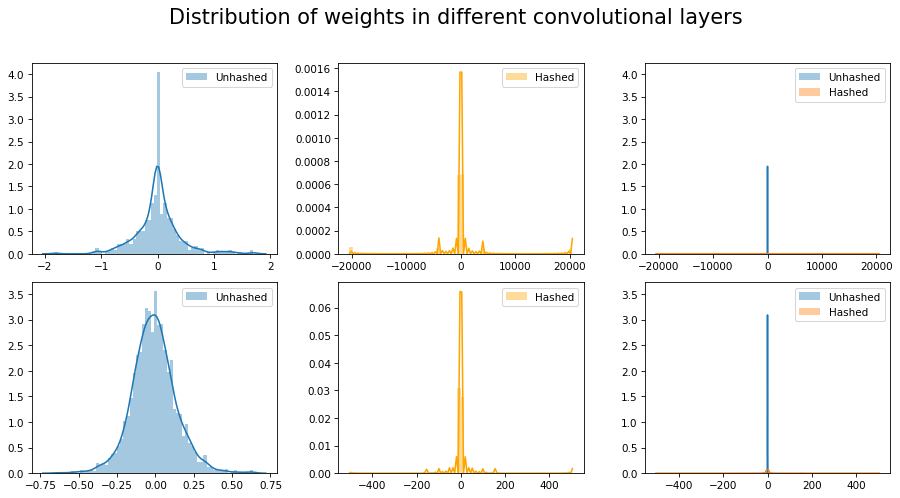

In [11]:
layer_paths = get_layers_path(model)
conv_layers = [ getattr_by_path_list(model,p) for p in layer_paths  ]
conv_layers = [x for x in conv_layers if isinstance(x,nn.Conv2d)]
to_view = [0,2,18,22]
conv_layers_model = [conv_layers[x] for x in to_view]

layer_paths = get_layers_path(hashed_model)
conv_layers = [ getattr_by_path_list(hashed_model,p) for p in layer_paths  ]
conv_layers = [x for x in conv_layers if isinstance(x,nn.Conv2d)]
to_view = [2,18,0,22]
to_view = [0,22] # Good perfomance
conv_layers_hashed_model = [conv_layers[x] for x in to_view]


# plotting

n = 2
fig, ax = plt.subplots(n,3, figsize=(12,6),dpi=75)

for i in range(n):
    layer = conv_layers_model[i]
    w = layer.weight.data
    j = 0
    ax[i][j] = sn.distplot(w.reshape(-1,1),bins=64,norm_hist=False,ax=ax[i][j],label="Unhashed")

    layer = conv_layers_hashed_model[i]
    j = 1
    w = layer.weight.data
    ax[i][j] = sn.distplot(w.reshape(-1,1),bins=64,norm_hist=False,
                           ax=ax[i][j],color='orange',label="Hashed")
    
    j = 2
    
    layer = conv_layers_model[i]
    w = layer.weight.data
    ax[i][j] = sn.distplot(w.reshape(-1,1),bins=64,norm_hist=False,ax=ax[i][j],label="Unhashed")

    layer = conv_layers_hashed_model[i]
    w = layer.weight.data
    ax[i][j] = sn.distplot(w.reshape(-1,1),bins=64,norm_hist=False,ax=ax[i][j],label="Hashed")

for i in range(n):
    for j in range(3):
        ax[i][j].legend()
fig.suptitle('Distribution of weights in different convolutional layers', position=(.5,1.1), fontsize=20)
fig.tight_layout()


# QuantConv2d

QuantConv2d abstracts the implementation details from the user,using quantization reduces to

```py
    from quantizer import quantizeModel
    
    @quantizeModel(n_bits=6,n_functions=8)
    class MyModel(nn.Module):
        ... model definition .. 
    
    model = MyModel()
    loss = loss + model.get_hash_loss()
    
```

In [12]:
fp = lambda x :f"./quantConvResent32_runs/resnet_32_{x}_64_logs"
n_fs = [3,4,6]


data = {}
for nf in n_fs:
    train_hash = pd.read_csv(
        ( pathlib.Path(fp(nf)) /  "run-.-tag-train_accuracy_hashed.csv") )["Value"]
    test_hash = pd.read_csv(
        pathlib.Path(fp(nf)) / "run-.-tag-test_accuracy_hashed.csv" )["Value"]
    train = pd.read_csv(
        pathlib.Path(fp(nf)) / "run-.-tag-train_accuracy_normal.csv" )["Value"]
    test = pd.read_csv(
        pathlib.Path(fp(nf)) / "run-.-tag-test_accuracy_normal.csv" )["Value"]
    
    d = {
        "train_hash":train_hash,
        "test_hash":test_hash,
        "train":train,
        "test":test,
    }
    data[nf] = d

Text(0.5, 1.0, 'Train accuracy vs Number of bits')

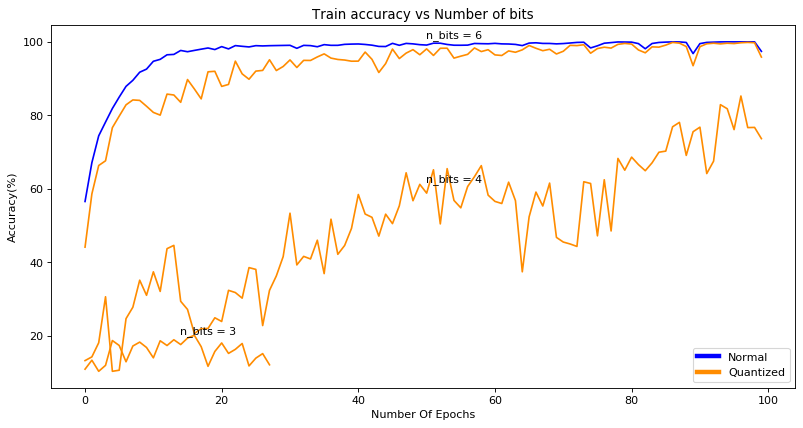

In [14]:
fig, ax = plt.subplots(1,1, figsize=(12,6),dpi=80)
n_fs = [3,4,6]
labels = [ f"n_bits = {x}" for x in n_fs ] 


val = data[6]["train"]*100
ax.plot(np.arange(len(val)),val,color="blue")

for nf,label in zip(n_fs,labels):
    val = data[nf]["train_hash"]*100
    x = np.arange(len(val))
    ax.plot(x,val,color="darkorange")
    
    k = int(len(x)/2)
    point = (x[k],val[k])
    
    ax.annotate(
            label,
            point,
            textcoords="offset points", # how to position the text
            xytext=(-1,10), 
            ha='left' 
    )
            
custom_lines = [
    Line2D([0], [0], color="blue", lw=4),
    Line2D([0], [0], color="darkorange", lw=4),
               ]

ax.legend(custom_lines, ['Normal','Quantized'])
ax.set_xlabel("Number Of Epochs")
ax.set_ylabel("Accuracy(%)")
ax.set_title("Train accuracy vs Number of bits")

Text(0.5, 1.0, 'Test accuracy vs Number of bits')

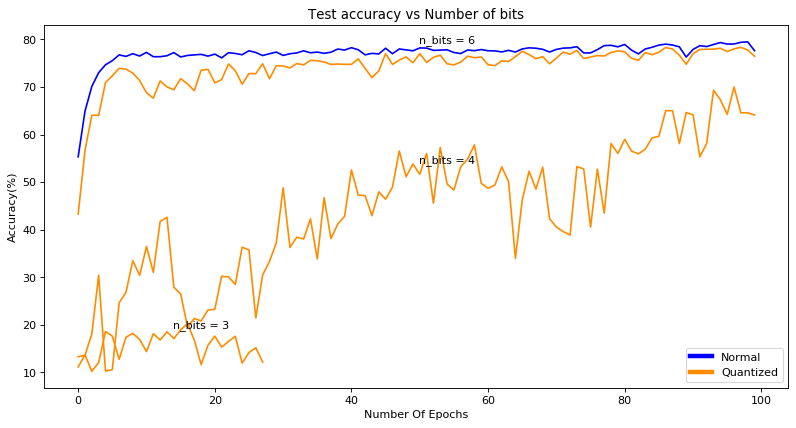

In [15]:
fig, ax = plt.subplots(1,1, figsize=(12,6),dpi=80)
n_fs = [3,4,6]
labels = [ f"n_bits = {x}" for x in n_fs ] 


val = data[6]["test"]*100
ax.plot(x,val,color="blue")

for nf,label in zip(n_fs,labels):
    val = data[nf]["test_hash"]*100
    x = np.arange(len(val))
    ax.plot(x,val,color="darkorange")
    
    k = int(len(x)/2)
    point = (x[k],val[k])
    
    ax.annotate(
            label,
            point,
            textcoords="offset points", # how to position the text
            xytext=(-1,10), 
            ha='left' 
    )
            
custom_lines = [
    Line2D([0], [0], color="blue", lw=4),
    Line2D([0], [0], color="darkorange", lw=4),
               ]

ax.legend(custom_lines, ['Normal','Quantized'])
ax.set_xlabel("Number Of Epochs")
ax.set_ylabel("Accuracy(%)")
ax.set_title("Test accuracy vs Number of bits")